In [ ]:
%pip install networkx

In [1]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Nodes
job = "JOB_DS"
skills = ["DS", "SW", "COM"]
candidates = ["C1", "C2", "C3", "C4"]

# Add nodes
G.add_node(job, type="job")
for s in skills:
    G.add_node(s, type="skill")
for c in candidates:
    G.add_node(c, type="candidate")


In [2]:
job_skill_weights = {
    "DS": 0.5,
    "SW": 0.25,
    "COM": 0.25
}

for skill, w in job_skill_weights.items():
    G.add_edge(job, skill, weight=w)


In [3]:
candidate_skills = {
    "C1": {"DS": 0.85, "SW": 0.40, "COM": 0.40},
    "C2": {"DS": 0.70, "SW": 0.70, "COM": 0.70},
    "C3": {"DS": 0.90, "SW": 0.10, "COM": 0.90},
    "C4": {"DS": 0.65, "SW": 0.85, "COM": 0.60},
}

for c, skills_dict in candidate_skills.items():
    for s, w in skills_dict.items():
        G.add_edge(s, c, weight=w)


In [4]:
personalization = {n: 0 for n in G.nodes()}
personalization[job] = 1.0

scores = nx.pagerank(
    G,
    alpha=0.85,
    personalization=personalization,
    weight="weight"
)


In [5]:
candidate_scores = {
    c: scores[c] for c in candidates
}

ranking = sorted(candidate_scores.items(), key=lambda x: x[1], reverse=True)

for c, score in ranking:
    print(c, round(score, 4))


C4 0.0748
C2 0.0746
C3 0.0685
C1 0.063


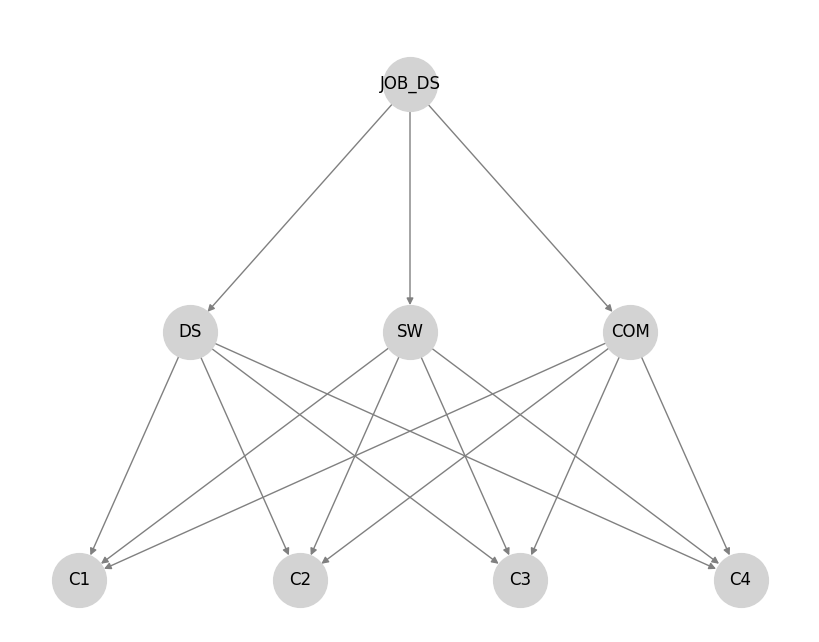

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

pos = {
    "JOB_DS": (0, 2),
    "DS": (-1, 1),
    "SW": (0, 1),
    "COM": (1, 1),
    "C1": (-1.5, 0),
    "C2": (-0.5, 0),
    "C3": (0.5, 0),
    "C4": (1.5, 0),
}

plt.figure(figsize=(8, 6))

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=1500,
    node_color="lightgray",
    edge_color="gray"
)

plt.title("Job → Skills → Candidates (Coverage & Complementarity)")
plt.show()


In [ ]:
# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    # Example data
    job_skills = {
        "Python": 0.9,
        "SQL": 0.7,
        "Leadership": 0.5,
        "Communication": 0.6
    }

    candidates = {
        "Alice": {
            "Python": 0.8,
            "SQL": 0.6,
            "Leadership": 0.4,
            "Communication": 0.7
        },
        "Bob": {
            "Python": 0.5,
            "SQL": 0.9,
            "Leadership": 0.7
            # Missing Communication
        },
        "Charlie": {
            "Python": 0.9,
            "SQL": 0.8,
            # Missing Leadership and Communication
        },
        "Diana": {
            "Python": 0.7,
            "SQL": 0.7,
            "Leadership": 0.6,
            "Communication": 0.8
        }
    }

    # Create ranker
    ranker = GraphBasedATSRanker()

    # Build graph
    ranker.build_graph(job_skills, candidates)
    print("Graph Statistics:")
    print(ranker.get_graph_stats())
    print()

    # Compute rankings
    rankings = ranker.compute_rankings()
    print("Rankings:")
    print(rankings)
    print()

    # Explain top candidate
    top_candidate = rankings.iloc[0]['candidate_id']
    explanation = ranker.explain_ranking(top_candidate)

    print(f"\nExplanation for {top_candidate} (Rank {explanation['rank']}):")
    print(f"Score: {explanation['score']:.6f}")
    print(f"Skill Coverage: {explanation['skill_coverage']:.1%}")
    print("\nTop Contributing Skills:")
    for skill in explanation['top_skills']:
        print(f"  - {skill['skill']}: proficiency={skill['proficiency']:.2f}, "
              f"importance={skill['importance']:.2f}, "
              f"contribution={skill['contribution']:.6f}")

    if explanation['missing_skills']:
        print("\nMissing Skills:")
        for skill in explanation['missing_skills']:
            print(f"  - {skill['skill']}: importance={skill['importance']:.2f}")


In [ ]:
# =============================================================================
# EXAMPLE / DEMO
# =============================================================================

if __name__ == "__main__":
    import os
    import tempfile

    print("="*80)
    print("JSON DATA LOADER - DEMO")
    print("="*80)
    print()

    # Create temporary directory for examples
    temp_dir = tempfile.mkdtemp()

    # ==========================================================================
    # FORMAT 1: Simple Format
    # ==========================================================================

    print("FORMAT 1: Simple Format (Recommended)")
    print("-" * 80)

    # Create example files
    job_simple = {
        "Python": 0.9,
        "SQL": 0.7,
        "Leadership": 0.5
    }

    candidates_simple = {
        "Alice": {
            "Python": 0.8,
            "SQL": 0.6,
            "Leadership": 0.4
        },
        "Bob": {
            "Python": 0.5,
            "SQL": 0.9,
            "Leadership": 0.7
        }
    }

    job_file = os.path.join(temp_dir, 'job_simple.json')
    cand_file = os.path.join(temp_dir, 'candidates_simple.json')

    with open(job_file, 'w') as f:
        json.dump(job_simple, f, indent=2)

    with open(cand_file, 'w') as f:
        json.dump(candidates_simple, f, indent=2)

    print(f"Created: {job_file}")
    print(f"Created: {cand_file}")
    print()

    print("job_simple.json:")
    print(json.dumps(job_simple, indent=2))
    print()

    print("candidates_simple.json:")
    print(json.dumps(candidates_simple, indent=2))
    print()

    # Load and rank
    print("Loading and ranking...")
    rankings = rank_from_json(job_file, cand_file)
    print(rankings)
    print()

    # ==========================================================================
    # FORMAT 2: Structured Format
    # ==========================================================================

    print("\n" + "="*80)
    print("FORMAT 2: Structured Format (With Metadata)")
    print("-" * 80)

    job_structured = {
        "job_id": "DS_2024_001",
        "title": "Senior Data Scientist",
        "skills": {
            "Python": 0.9,
            "SQL": 0.7,
            "Leadership": 0.5
        }
    }

    candidates_structured = {
        "candidates": [
            {
                "id": "Alice",
                "name": "Alice Johnson",
                "skills": {
                    "Python": 0.8,
                    "SQL": 0.6,
                    "Leadership": 0.4
                }
            },
            {
                "id": "Bob",
                "name": "Bob Smith",
                "skills": {
                    "Python": 0.5,
                    "SQL": 0.9,
                    "Leadership": 0.7
                }
            }
        ]
    }

    job_file2 = os.path.join(temp_dir, 'job_structured.json')
    cand_file2 = os.path.join(temp_dir, 'candidates_structured.json')

    with open(job_file2, 'w') as f:
        json.dump(job_structured, f, indent=2)

    with open(cand_file2, 'w') as f:
        json.dump(candidates_structured, f, indent=2)

    print("job_structured.json:")
    print(json.dumps(job_structured, indent=2))
    print()

    print("candidates_structured.json (truncated):")
    print(json.dumps(candidates_structured['candidates'][0], indent=2))
    print("...")
    print()

    # Load and rank
    print("Loading and ranking...")
    rankings2 = rank_from_json(job_file2, cand_file2)
    print(rankings2)
    print()

    # ==========================================================================
    # FORMAT 3: Skills with Required/Preferred
    # ==========================================================================

    print("\n" + "="*80)
    print("FORMAT 3: Required/Preferred Skills")
    print("-" * 80)

    job_categorized = {
        "required": {
            "Python": 0.95,
            "SQL": 0.85
        },
        "preferred": {
            "Leadership": 0.6,
            "Communication": 0.5
        },
        "nice_to_have": {
            "AWS": 0.3
        }
    }

    job_file3 = os.path.join(temp_dir, 'job_categorized.json')

    with open(job_file3, 'w') as f:
        json.dump(job_categorized, f, indent=2)

    print("job_categorized.json:")
    print(json.dumps(job_categorized, indent=2))
    print()

    # Load (just the job this time)
    job_skills = ATSDataLoader.load_job_requirements(job_file3)
    print("Loaded as:")
    print(job_skills)
    print()

    # ==========================================================================
    # VALIDATION
    # ==========================================================================

    print("\n" + "="*80)
    print("DATA VALIDATION")
    print("-" * 80)

    # Valid data
    valid_job = {"Python": 0.9, "SQL": 0.7}
    valid_candidates = {"Alice": {"Python": 0.8, "SQL": 0.6}}

    is_valid, errors = ATSDataLoader.validate_data(valid_job, valid_candidates)
    print(f"Valid data: {is_valid}")
    print()

    # Invalid data
    invalid_job = {"Python": 1.5}  # Out of range
    invalid_candidates = {"Bob": {"Python": -0.2}}  # Negative

    is_valid, errors = ATSDataLoader.validate_data(invalid_job, invalid_candidates)
    print(f"Invalid data: {is_valid}")
    if errors:
        print("Errors found:")
        for error in errors:
            print(f"  - {error}")
    print()

    # ==========================================================================
    # SUMMARY
    # ==========================================================================

    print("="*80)
    print("SUMMARY")
    print("="*80)

    summary = """
The JSON loader supports multiple formats for maximum flexibility:

1. SIMPLE FORMAT (Recommended for new projects)
   - Job: {"skill": importance, ...}
   - Candidates: {"id": {"skill": proficiency, ...}, ...}

2. STRUCTURED FORMAT (Good for production systems)
   - Job: {"job_id": "...", "skills": {...}}
   - Candidates: {"candidates": [{"id": "...", "skills": {...}}, ...]}

3. CATEGORIZED FORMAT (When you have required/preferred/nice-to-have)
   - Job: {"required": {...}, "preferred": {...}}

USAGE:
------
from json_loader import rank_from_json

# One line!
rankings = rank_from_json('job.json', 'candidates.json')

OR:

from json_loader import ATSDataLoader
from graph_ats_ranker import rank_candidates

job_skills, candidates = ATSDataLoader.load_from_json('job.json', 'candidates.json')
rankings = rank_candidates(job_skills, candidates)

All formats work - choose what fits your existing data structure!
"""

    print(summary)

    # Cleanup
    import shutil
    shutil.rmtree(temp_dir)
    print(f"Cleaned up temporary files in {temp_dir}")


In [ ]:
def explain_candidate(
    job_skills: Dict[str, float],
    candidates: Dict[str, Dict[str, float]],
    candidate_id: str,
    top_k_skills: int = 5
) -> Dict:
    """
    One-shot function to explain a candidate's ranking.
    """
    ranker = GraphBasedATSRanker()
    ranker.build_graph(job_skills, candidates)
    ranker.compute_rankings()
    return ranker.explain_ranking(candidate_id, top_k_skills)
